In [2]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
import helpers

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [4]:
# Pre-processed MFCC coefficients
X = np.load("C:/Users/ishaa/OneDrive/Desktop/extracted features/X-MFCC.npy")
y = np.load("C:/Users/ishaa/OneDrive/Desktop/extracted features/Y-MFCC.npy")

# Metadata
path = 'C:/Users/ishaa/OneDrive/Desktop/dataset/'
file = 'UrbanSound8K.csv'

# Use pandas read_csv directly
meta_data = pd.read_csv(path + file)
meta_data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
def split_data(x,y,train=[],test=[],meta_data=meta_data):
    x_train,y_train=[],[]
    training_indexes,test_indexes=[],[]
    for ind in train:
        training_indexes=training_indexes+[idx_ for idx_ in meta_data.loc[(meta_data['fold'] == ind)].index.values]
    x_train=[ x[i] for i in sorted(training_indexes)]
    y_train=[ y[i] for i in sorted(training_indexes)]
    for ind in test:
        test_indexes=test_indexes+[idx_ for idx_ in meta_data.loc[(meta_data['fold'] == ind)].index.values]
    x_test=[ x[i] for i in sorted(test_indexes)]
    y_test=[ y[i] for i in sorted(test_indexes)]
    return np.array(x_train) , np.array( y_train ) ,np.array(  x_test ) , np.array( y_test) ,training_indexes,test_indexes


# 1. Data preparation: features + metadata

1. Data preparation: features + metadata 

In [6]:
indexes = []
total = len(meta_data)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes

X_train,y_train,X_test,y_test,train_split_idx,test_split_idx= split_data(X,y,train=[1,2,3,4,6],test=[5,7,8,9,10])

# Also split metadata
test_meta = meta_data.iloc[test_split_idx]
train_meta = meta_data.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 4233 		 Train split: 4499
X test shape: (4233, 40, 174) 	 X train shape: (4499, 40, 174)
y test shape: (4233,) 		 y train shape: (4499,)


# Normalizing the Data

One hot encode labels

In [7]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

Reshape data

In [8]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]
# Train Shape
X_train.shape

(4499, 40, 174, 1)

Check PCA benefits

Text(0, 0.5, 'Variance (%)')

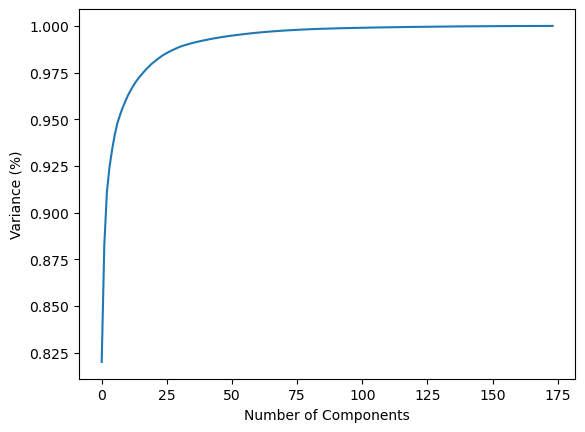

In [9]:
scaler = StandardScaler()
scaler.fit(X_train[:,0, ::,0])
x_train_scaled = scaler.transform(X_train[:,0, ::,0])

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')

As we can see most of the variance is explained using all the features of the MFCC. This is expected since each feature gives information about the wave shape. Finally we can fit our model.

# CNN Model

In [10]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)


# Setup model optimizer and loss function

Using ADAM with default parameters to start from somewhere, then reduced learning rate to 1e-4 (as loss history was noisy). Loss function is categorical cross-entropy as we are predicting between 10 classes.

In [12]:
adam = Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 172, 32)       320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 38, 172, 32)       0         
                                                                 
 batch_normalization (Batch  (None, 38, 172, 32)       128       
 Normalization)                                                  
                                                                 
 spatial_dropout2d (Spatial  (None, 38, 172, 32)       0         
 Dropout2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 170, 32)       9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 36, 170, 32)       0

# Training the model

In [13]:
num_epochs = 250
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/250
33/33 [==============================] - ETA: 0s - loss: 2.2688 - accuracy: 0.1843
Epoch 1: val_loss improved from inf to 2.29938, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 79s 2s/step - loss: 2.2688 - accuracy: 0.1843 - val_loss: 2.2994 - val_accuracy: 0.1040
Epoch 2/250
33/33 [==============================] - ETA: 0s - loss: 1.9983 - accuracy: 0.3075
Epoch 2: val_loss improved from 2.29938 to 2.25949, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 74s 2s/step - loss: 1.9983 - accuracy: 0.3075 - val_loss: 2.2595 - val_accuracy: 0.1173
Epoch 3/250
33/33 [==============================] - ETA: 0s - loss: 1.8725 - accuracy: 0.3681
Epoch 3: val_loss improved from 2.25949 to 2.21564, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 73s 2s/step - loss: 1.8725 - accuracy: 0.3681 - val_lo

Epoch 26/250
33/33 [==============================] - ETA: 0s - loss: 1.2550 - accuracy: 0.6089
Epoch 26: val_loss improved from 1.60623 to 1.58975, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 72s 2s/step - loss: 1.2550 - accuracy: 0.6089 - val_loss: 1.5898 - val_accuracy: 0.4880
Epoch 27/250
33/33 [==============================] - ETA: 0s - loss: 1.2352 - accuracy: 0.6081
Epoch 27: val_loss improved from 1.58975 to 1.58716, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 72s 2s/step - loss: 1.2352 - accuracy: 0.6081 - val_loss: 1.5872 - val_accuracy: 0.4880
Epoch 28/250
33/33 [==============================] - ETA: 0s - loss: 1.2202 - accuracy: 0.6205
Epoch 28: val_loss did not improve from 1.58716
33/33 [==============================] - 72s 2s/step - loss: 1.2202 - accuracy: 0.6205 - val_loss: 1.5968 - val_accuracy: 0.4667
Epoch 29/250
33/33 [===========

33/33 [==============================] - 72s 2s/step - loss: 0.9900 - accuracy: 0.7088 - val_loss: 1.4765 - val_accuracy: 0.5360
Epoch 53/250
33/33 [==============================] - ETA: 0s - loss: 0.9825 - accuracy: 0.7047
Epoch 53: val_loss did not improve from 1.46082
33/33 [==============================] - 73s 2s/step - loss: 0.9825 - accuracy: 0.7047 - val_loss: 1.4701 - val_accuracy: 0.5280
Epoch 54/250
33/33 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.7020
Epoch 54: val_loss did not improve from 1.46082
33/33 [==============================] - 73s 2s/step - loss: 0.9798 - accuracy: 0.7020 - val_loss: 1.4808 - val_accuracy: 0.5227
Epoch 55/250
33/33 [==============================] - ETA: 0s - loss: 0.9828 - accuracy: 0.6991
Epoch 55: val_loss did not improve from 1.46082
33/33 [==============================] - 72s 2s/step - loss: 0.9828 - accuracy: 0.6991 - val_loss: 1.4846 - val_accuracy: 0.5387
Epoch 56/250
33/33 [==============================] 

33/33 [==============================] - ETA: 0s - loss: 0.8070 - accuracy: 0.7730
Epoch 81: val_loss did not improve from 1.42703
33/33 [==============================] - 73s 2s/step - loss: 0.8070 - accuracy: 0.7730 - val_loss: 1.4456 - val_accuracy: 0.5760
Epoch 82/250
33/33 [==============================] - ETA: 0s - loss: 0.8134 - accuracy: 0.7742
Epoch 82: val_loss did not improve from 1.42703
33/33 [==============================] - 72s 2s/step - loss: 0.8134 - accuracy: 0.7742 - val_loss: 1.4438 - val_accuracy: 0.5653
Epoch 83/250
33/33 [==============================] - ETA: 0s - loss: 0.7991 - accuracy: 0.7689
Epoch 83: val_loss did not improve from 1.42703
33/33 [==============================] - 74s 2s/step - loss: 0.7991 - accuracy: 0.7689 - val_loss: 1.4353 - val_accuracy: 0.5307
Epoch 84/250
33/33 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.7762
Epoch 84: val_loss did not improve from 1.42703
33/33 [==============================] - 74s 2s/st

33/33 [==============================] - 54s 2s/step - loss: 0.7021 - accuracy: 0.7990 - val_loss: 1.4755 - val_accuracy: 0.5573
Epoch 111/250
33/33 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.8094
Epoch 111: val_loss did not improve from 1.40956
33/33 [==============================] - 48s 1s/step - loss: 0.6857 - accuracy: 0.8094 - val_loss: 1.4863 - val_accuracy: 0.5760
Epoch 112/250
33/33 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.8094
Epoch 112: val_loss did not improve from 1.40956
33/33 [==============================] - 52s 2s/step - loss: 0.6892 - accuracy: 0.8094 - val_loss: 1.4898 - val_accuracy: 0.5653
Epoch 113/250
33/33 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.8067
Epoch 113: val_loss did not improve from 1.40956
33/33 [==============================] - 59s 2s/step - loss: 0.6916 - accuracy: 0.8067 - val_loss: 1.5152 - val_accuracy: 0.5573
Epoch 114/250
33/33 [=========================

33/33 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.8387
Epoch 140: val_loss did not improve from 1.40956
33/33 [==============================] - 48s 1s/step - loss: 0.5939 - accuracy: 0.8387 - val_loss: 1.5047 - val_accuracy: 0.5600
Epoch 141/250
33/33 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.8431
Epoch 141: val_loss did not improve from 1.40956
33/33 [==============================] - 48s 1s/step - loss: 0.5977 - accuracy: 0.8431 - val_loss: 1.4752 - val_accuracy: 0.5680
Epoch 142/250
33/33 [==============================] - ETA: 0s - loss: 0.5948 - accuracy: 0.8375
Epoch 142: val_loss did not improve from 1.40956
33/33 [==============================] - 48s 1s/step - loss: 0.5948 - accuracy: 0.8375 - val_loss: 1.4910 - val_accuracy: 0.5600
Epoch 143/250
33/33 [==============================] - ETA: 0s - loss: 0.5935 - accuracy: 0.8429
Epoch 143: val_loss did not improve from 1.40956
33/33 [==============================] - 49

Epoch 170/250
33/33 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.8632
Epoch 170: val_loss did not improve from 1.40956
33/33 [==============================] - 50s 2s/step - loss: 0.5332 - accuracy: 0.8632 - val_loss: 1.5443 - val_accuracy: 0.5600
Epoch 171/250
33/33 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.8601
Epoch 171: val_loss did not improve from 1.40956
33/33 [==============================] - 49s 1s/step - loss: 0.5323 - accuracy: 0.8601 - val_loss: 1.5529 - val_accuracy: 0.5253
Epoch 172/250
33/33 [==============================] - ETA: 0s - loss: 0.5211 - accuracy: 0.8594
Epoch 172: val_loss did not improve from 1.40956
33/33 [==============================] - 49s 1s/step - loss: 0.5211 - accuracy: 0.8594 - val_loss: 1.5089 - val_accuracy: 0.5600
Epoch 173/250
33/33 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.8598
Epoch 173: val_loss did not improve from 1.40956
33/33 [======================

Epoch 200/250
33/33 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.8754
Epoch 200: val_loss did not improve from 1.40956
33/33 [==============================] - 49s 1s/step - loss: 0.4808 - accuracy: 0.8754 - val_loss: 1.5671 - val_accuracy: 0.5680
Epoch 201/250
33/33 [==============================] - ETA: 0s - loss: 0.4815 - accuracy: 0.8751
Epoch 201: val_loss did not improve from 1.40956
33/33 [==============================] - 48s 1s/step - loss: 0.4815 - accuracy: 0.8751 - val_loss: 1.5527 - val_accuracy: 0.5787
Epoch 202/250
33/33 [==============================] - ETA: 0s - loss: 0.4648 - accuracy: 0.8800
Epoch 202: val_loss did not improve from 1.40956
33/33 [==============================] - 49s 1s/step - loss: 0.4648 - accuracy: 0.8800 - val_loss: 1.5678 - val_accuracy: 0.5707
Epoch 203/250
33/33 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.8758
Epoch 203: val_loss did not improve from 1.40956
33/33 [======================

Epoch 230/250
33/33 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.8965
Epoch 230: val_loss did not improve from 1.40956
33/33 [==============================] - 52s 2s/step - loss: 0.4282 - accuracy: 0.8965 - val_loss: 1.6115 - val_accuracy: 0.5493
Epoch 231/250
33/33 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.8974
Epoch 231: val_loss did not improve from 1.40956
33/33 [==============================] - 53s 2s/step - loss: 0.4262 - accuracy: 0.8974 - val_loss: 1.6238 - val_accuracy: 0.5547
Epoch 232/250
33/33 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8911
Epoch 232: val_loss did not improve from 1.40956
33/33 [==============================] - 53s 2s/step - loss: 0.4290 - accuracy: 0.8911 - val_loss: 1.6285 - val_accuracy: 0.5627
Epoch 233/250
33/33 [==============================] - ETA: 0s - loss: 0.4208 - accuracy: 0.8921
Epoch 233: val_loss did not improve from 1.40956
33/33 [======================

# General model evaluation

We first load the checkpoint with the lowest validation loss achieved during training. We then use the Test set to evaluate the model with data that has not been seen by the model nor by me when tuning hyper-parameters.

In [14]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.6775       82.9740
Test:             1.1554       64.0680
Normal diff         41.36 


In [24]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

# Confusion Matrix

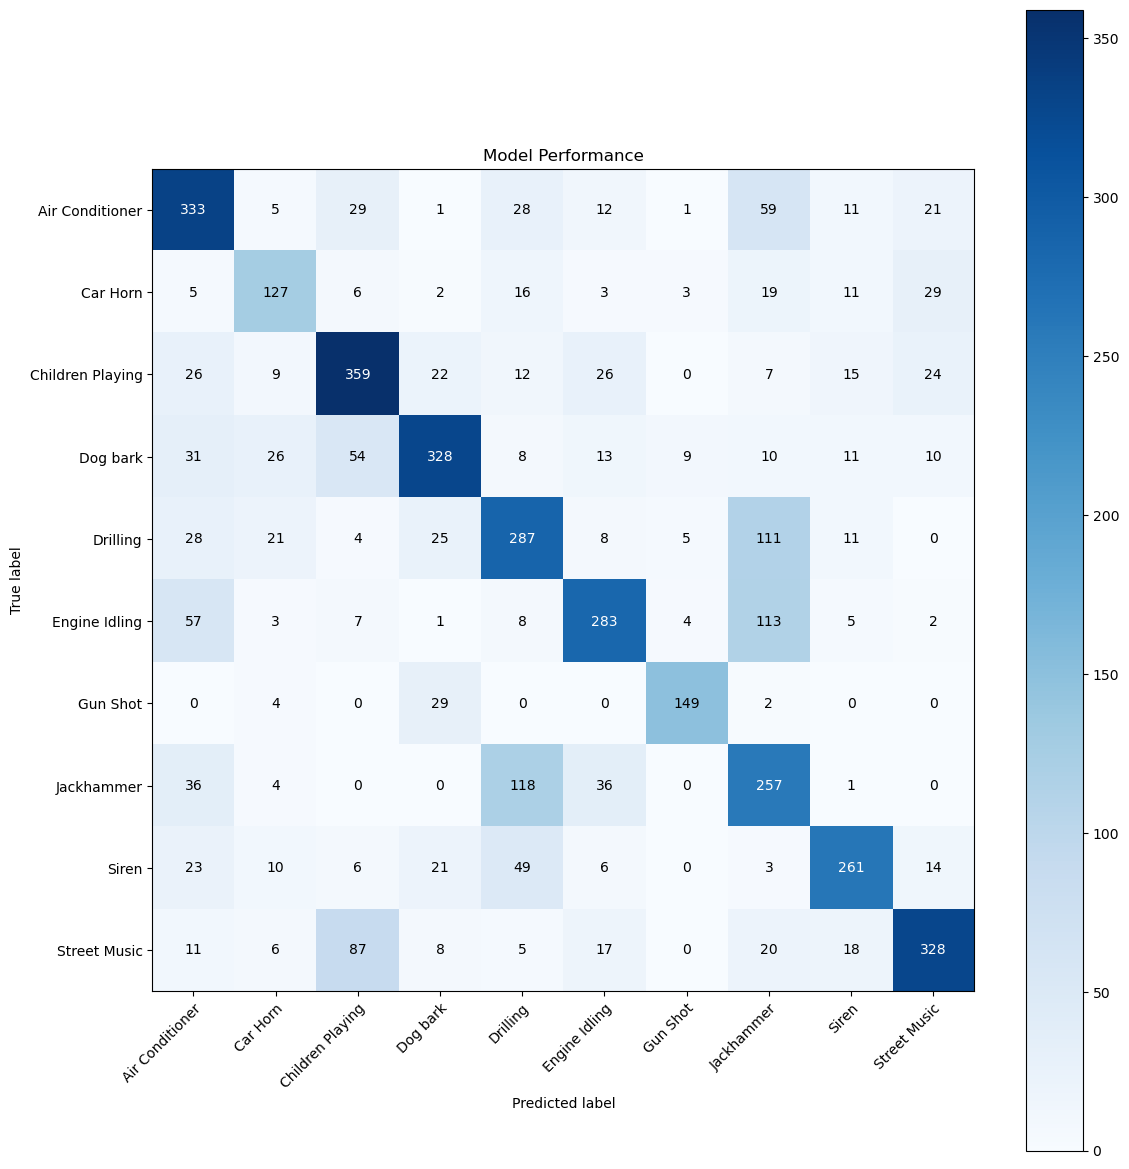

In [25]:
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

# Accuracy Table

In [26]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,80.978261
2,Children Playing,71.800000
0,Air Conditioner,66.600000
8,Siren,66.412214
3,Dog bark,65.600000
9,Street Music,65.600000
5,Engine Idling,58.592133
1,Car Horn,57.466063
4,Drilling,57.400000
7,Jackhammer,56.858407


# Classification performance: Presicion, Recall and F1 scores

In [27]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.61      0.67      0.63       500
        Car Horn       0.59      0.57      0.58       221
Children Playing       0.65      0.72      0.68       500
        Dog bark       0.75      0.66      0.70       500
        Drilling       0.54      0.57      0.56       500
   Engine Idling       0.70      0.59      0.64       483
        Gun Shot       0.87      0.81      0.84       184
      Jackhammer       0.43      0.57      0.49       452
           Siren       0.76      0.66      0.71       393
    Street Music       0.77      0.66      0.71       500

        accuracy                           0.64      4233
       macro avg       0.67      0.65      0.65      4233
    weighted avg       0.66      0.64      0.65      4233



# Exploring the misclassified

Street music as Children playing

In [29]:
# Find the target misclassified ocurrencies
street_as_children = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 2)]

files = []
for idx, row in street_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)
    

In [30]:
print("Children playing as Street music: {} ocurrencies".format(len(street_as_children)))

# Manully set the file index
index = 12
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

Children playing as Street music: 94 ocurrencies

True category: street_music
File: C:\Users\ishaa\USC_final\UrbanSound8K\audio/fold7/36264-9-0-7.wav


Drilling as Jack Hammer

In [31]:
# Find the target misclassified ocurrencies
drilling_as_jack = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 7)]
files = []
for idx, row in drilling_as_jack.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [32]:
print("Drilling as Jack Hammer: {} ocurrencies".format(len(drilling_as_jack)))

# Manully set the file index
index = 3
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

Drilling as Jack Hammer: 71 ocurrencies

True category: drilling
File: C:\Users\ishaa\USC_final\UrbanSound8K\audio/fold5/118440-4-6-0.wav


Dog Bark as Children Playing

In [33]:
# Drilling as Air Conditioner
dogbar_as_children = test_meta[(test_meta['classID'] == 3) & (test_meta['pred'] == 2)]

files = []
for idx, row in dogbar_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [34]:
print("Dog Bark as Children Playing: {} ocurrencies".format(len(dogbar_as_children)))
    
# Manully set the file index
index = 8
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

Dog Bark as Children Playing: 57 ocurrencies

True category: dog_bark
File: C:\Users\ishaa\USC_final\UrbanSound8K\audio/fold5/77233-3-0-7.wav
